In [ ]:
import numpy as np
import math
from gnpy.core.info import create_input_spectral_information, create_arbitrary_spectral_information, automatic_nch
from gnpy.core.elements import Fiber, Transceiver
from gnpy.core.utils import watt2dbm, db2lin, dbm2watt, lin2db
import matplotlib.pyplot as plt



In [9]:
def simular_red_por_tramos(tx_power_dbm=16.53,
                           sensibilidad_receptor_dbm=-28,
                           tramos_params=None):
    """
    tramos_params: lista de diccionarios con parámetros por tramo, ej:
    [
        {'loss_coef': 0.2, 'att_in': 0, 'con_in': 0.25, 'con_out': 0.30, 'length': 20},
        {'loss_coef': 0.22, 'att_in': 0.01, 'con_in': 0.25, 'con_out': 0.3, 'length': 30},
        {'loss_coef': 0.19, 'att_in': 0, 'con_in': 0.20, 'con_out': 0.25, 'length': 15},
    ]
    """

    if tramos_params is None:
        raise ValueError("Debes proporcionar los parámetros de los tramos")

    power_history_dbm = [tx_power_dbm]
    power_history_linear = [db2lin(tx_power_dbm)]
    longitud_acumulada = [0]
    current_power_dbm = tx_power_dbm

    num_tramos = len(tramos_params)

    for i, params in enumerate(tramos_params):
        longitud_tramo = params.get('length', 5)
        loss_coef = params.get('loss_coef', 0.2)
        att_in = params.get('att_in', 0)
        con_in = params.get('con_in', 0.25)
        con_out = params.get('con_out', 0.30)

        num_segmentos = int(np.ceil(longitud_tramo / 5))
        potencia_inicial_tramo = current_power_dbm

        for j in range(num_segmentos):
            segment_length = min(5, longitud_tramo - j * 5)
            attenuation_segment_db = loss_coef * segment_length
            current_power_dbm -= attenuation_segment_db
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1] + segment_length)

        # Pérdidas de conectores entre tramos excepto último tramo
        if i < num_tramos - 1:
            current_power_dbm -= con_out
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= con_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= att_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

        else:
            # Último tramo, aplicar también pérdidas
            current_power_dbm -= con_out
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= con_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= att_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

    resultados = {
        'power_history_dbm': power_history_dbm,
        'power_history_linear': power_history_linear,
        'longitud_acumulada': longitud_acumulada,
        'potencia_final_dbm': power_history_dbm[-1],
        'atenuacion_total': tx_power_dbm - power_history_dbm[-1],
        'sensibilidad_receptor_dbm': sensibilidad_receptor_dbm,
    }

    return resultados



Potencia de la señal inicial (dBm): 67.00
Potencia de la señal recibida (dBm): 30.40
Potencia de la señal recibida (mW): 1096.48
Atenuación total simulada (dB): 36.60
Sensibilidad del receptor (dBm): 34.00

Advertencia: La potencia de la señal recibida es menor que la sensibilidad del receptor.


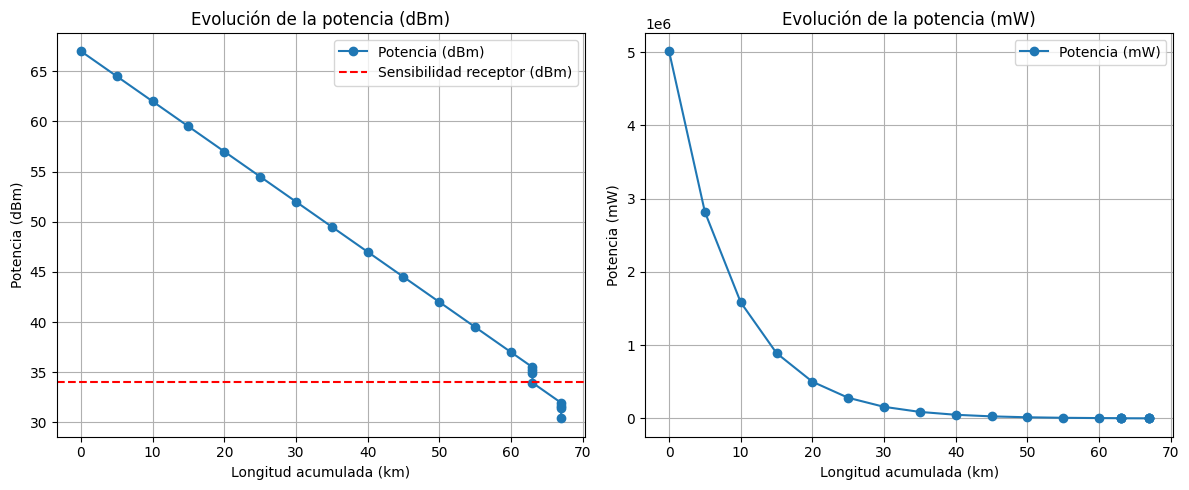

In [10]:
# Definir parámetros para la simulación (puedes cambiar aquí para probar)
tx_power_dbm = 67
sensibilidad_receptor_dbm = 34
fibra_params = {
    'loss_coef': 0.5,
    'att_in': 1,
    'con_in': 0.25,
    'con_out': 0.30,
}
num_tramos = 2
longitudes_tramos = [63, 4]  # km para tramo 1 y 2

# Ejecutar simulación
resultados = simular_red(
    tx_power_dbm=tx_power_dbm,
    sensibilidad_receptor_dbm=sensibilidad_receptor_dbm,
    fibra_params=fibra_params,
    num_tramos=num_tramos,
    longitudes_tramos=longitudes_tramos
)

print(f"Potencia de la señal inicial (dBm): {tx_power_dbm:.2f}")
print(f"Potencia de la señal recibida (dBm): {resultados['potencia_final_dbm']:.2f}")
print(f"Potencia de la señal recibida (mW): {db2lin(resultados['potencia_final_dbm']):.2f}")
print(f"Atenuación total simulada (dB): {resultados['atenuacion_total']:.2f}")
print(f"Sensibilidad del receptor (dBm): {sensibilidad_receptor_dbm:.2f}")

if resultados['potencia_final_dbm'] < sensibilidad_receptor_dbm:
    print("\nAdvertencia: La potencia de la señal recibida es menor que la sensibilidad del receptor.")

# Definir función para graficar resultados
def graficar_potencia(longitud_acumulada, power_history_dbm, power_history_linear, sensibilidad_receptor_dbm):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(longitud_acumulada, power_history_dbm, marker='o', label='Potencia (dBm)')
    plt.axhline(y=sensibilidad_receptor_dbm, color='r', linestyle='--', label='Sensibilidad receptor (dBm)')
    plt.xlabel('Longitud acumulada (km)')
    plt.ylabel('Potencia (dBm)')
    plt.title('Evolución de la potencia (dBm)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(longitud_acumulada, power_history_linear, marker='o', label='Potencia (mW)')
    plt.xlabel('Longitud acumulada (km)')
    plt.ylabel('Potencia (mW)')
    plt.title('Evolución de la potencia (mW)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Graficar resultados
graficar_potencia(
    resultados['longitud_acumulada'],
    resultados['power_history_dbm'],
    resultados['power_history_linear'],
    sensibilidad_receptor_dbm
)


=== Simulación de red óptica con tramos independientes ===

Tramo 1:

Configuración del tramo 1:

Tramo 2:

Configuración del tramo 2:

Potencia de la señal inicial (dBm): 52.00
Potencia de la señal recibida (dBm): 36.12
Potencia de la señal recibida (mW): 4092.61
Atenuación total simulada (dB): 15.88
Sensibilidad del receptor (dBm): 74.00

Advertencia: La potencia de la señal recibida es menor que la sensibilidad del receptor.


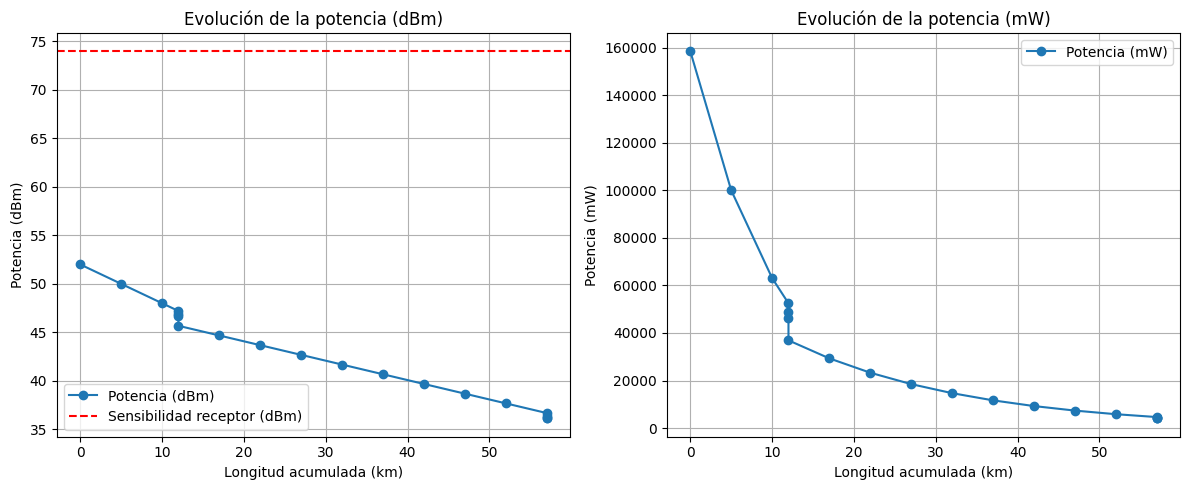

In [11]:
def solicitar_float(mensaje, valor_por_defecto=None, minimo=None, maximo=None):
    while True:
        try:
            entrada = input(f"{mensaje} " + (f"[Por defecto: {valor_por_defecto}]: " if valor_por_defecto is not None else ": "))
            if entrada == "" and valor_por_defecto is not None:
                return valor_por_defecto
            valor = float(entrada)
            if minimo is not None and valor < minimo:
                print(f"El valor debe ser al menos {minimo}. Intenta de nuevo.")
                continue
            if maximo is not None and valor > maximo:
                print(f"El valor debe ser máximo {maximo}. Intenta de nuevo.")
                continue
            return valor
        except ValueError:
            print("Entrada inválida. Ingresa un número válido.")

def solicitar_int(mensaje, minimo=None, maximo=None):
    while True:
        try:
            valor = int(input(mensaje + ": "))
            if minimo is not None and valor < minimo:
                print(f"El valor debe ser al menos {minimo}. Intenta de nuevo.")
                continue
            if maximo is not None and valor > maximo:
                print(f"El valor debe ser máximo {maximo}. Intenta de nuevo.")
                continue
            return valor
        except ValueError:
            print("Entrada inválida. Ingresa un número entero válido.")

def pedir_parametros_tramo(tramo_num, valores_default):
    print(f"\nConfiguración del tramo {tramo_num}:")
    cambiar = input("¿Desea cambiar los parámetros de la fibra de este tramo? (s/n): ").lower()
    if cambiar == "s":
        loss_coef = solicitar_float("Coeficiente de pérdida (dB/km)", valores_default['loss_coef'], minimo=0)
        att_in = solicitar_float("Pérdida atenuación interna (dB)", valores_default['att_in'], minimo=0)
        con_in = solicitar_float("Pérdida conector entrada (dB)", valores_default['con_in'], minimo=0)
        con_out = solicitar_float("Pérdida conector salida (dB)", valores_default['con_out'], minimo=0)
        return {
            'loss_coef': loss_coef,
            'att_in': att_in,
            'con_in': con_in,
            'con_out': con_out
        }
    else:
        return valores_default.copy()

def main_interactivo():
    print("=== Simulación de red óptica con tramos independientes ===")
    # Parámetros transmisor y receptor
    tx_power_dbm = solicitar_float("Introduce la potencia de entrada (dBm)", valor_por_defecto=16.53)
    sensibilidad_receptor_dbm = solicitar_float("Introduce la sensibilidad del receptor (dBm)", valor_por_defecto=-28)

    num_tramos = solicitar_int("Introduce el número de tramos de fibra (1 a 4)", minimo=1, maximo=4)

    # Definir valores por defecto para la fibra
    valores_default_fibra = {
        'loss_coef': 0.2,
        'att_in': 0,
        'con_in': 0.25,
        'con_out': 0.30,
    }

    tramos_params = []

    # Pedir longitud y parámetros para cada tramo
    for i in range(num_tramos):
        print(f"\nTramo {i+1}:")
        longitud = solicitar_float("Introduce la longitud del tramo (km)", minimo=0.1)
        fibra_parametros = pedir_parametros_tramo(i+1, valores_default_fibra)
        fibra_parametros['length'] = longitud
        tramos_params.append(fibra_parametros)

    # Ejecutar simulación
    resultados = simular_red_por_tramos(
        tx_power_dbm=tx_power_dbm,
        sensibilidad_receptor_dbm=sensibilidad_receptor_dbm,
        tramos_params=tramos_params
    )

    # Mostrar resultados
    print(f"\nPotencia de la señal inicial (dBm): {tx_power_dbm:.2f}")
    print(f"Potencia de la señal recibida (dBm): {resultados['potencia_final_dbm']:.2f}")
    print(f"Potencia de la señal recibida (mW): {db2lin(resultados['potencia_final_dbm']):.2f}")
    print(f"Atenuación total simulada (dB): {resultados['atenuacion_total']:.2f}")
    print(f"Sensibilidad del receptor (dBm): {sensibilidad_receptor_dbm:.2f}")

    if resultados['potencia_final_dbm'] < sensibilidad_receptor_dbm:
        print("\nAdvertencia: La potencia de la señal recibida es menor que la sensibilidad del receptor.")

    # Graficar resultados
    graficar_potencia(
        resultados['longitud_acumulada'],
        resultados['power_history_dbm'],
        resultados['power_history_linear'],
        sensibilidad_receptor_dbm
    )

# Finalmente, ejecuta la función principal para comenzar el flujo interactivo
main_interactivo()


In [12]:
def simular_red_por_tramos_detallado(tx_power_dbm=16.53,
                                     sensibilidad_receptor_dbm=-28,
                                     tramos_params=None):
    """
    Igual que antes, pero retorna detalles por tramo para impresión fina.
    """
    if tramos_params is None:
        raise ValueError("Debes proporcionar los parámetros de los tramos")

    power_history_dbm = [tx_power_dbm]
    power_history_linear = [db2lin(tx_power_dbm)]
    longitud_acumulada = [0]
    current_power_dbm = tx_power_dbm

    num_tramos = len(tramos_params)

    # Para almacenar resultados intermedios por tramo
    detalles_tramos = []

    for i, params in enumerate(tramos_params):
        longitud_tramo = params.get('length', 5)
        loss_coef = params.get('loss_coef', 0.2)
        att_in = params.get('att_in', 0)
        con_in = params.get('con_in', 0.25)
        con_out = params.get('con_out', 0.30)

        num_segmentos = int(np.ceil(longitud_tramo / 5))
        potencia_inicial_tramo = current_power_dbm

        for j in range(num_segmentos):
            segment_length = min(5, longitud_tramo - j * 5)
            attenuation_segment_db = loss_coef * segment_length
            current_power_dbm -= attenuation_segment_db
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1] + segment_length)

        # Pérdidas de conectores
        if i < num_tramos - 1:
            current_power_dbm -= con_out
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= con_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= att_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])
        else:
            # Último tramo
            current_power_dbm -= con_out
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= con_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

            current_power_dbm -= att_in
            power_history_dbm.append(current_power_dbm)
            power_history_linear.append(db2lin(current_power_dbm))
            longitud_acumulada.append(longitud_acumulada[-1])

        potencia_final_tramo = power_history_dbm[-1]
        atenuacion_tramo = potencia_inicial_tramo - potencia_final_tramo
        longitud_acum_tramo = longitud_acumulada[-1]

        detalles_tramos.append({
            'numero': i + 1,
            'longitud_acumulada': longitud_acum_tramo,
            'potencia_final_dbm': potencia_final_tramo,
            'atenuacion_tramo': atenuacion_tramo,
            'longitud_tramo': longitud_tramo,
        })

    resultados = {
        'power_history_dbm': power_history_dbm,
        'power_history_linear': power_history_linear,
        'longitud_acumulada': longitud_acumulada,
        'potencia_final_dbm': power_history_dbm[-1],
        'atenuacion_total': tx_power_dbm - power_history_dbm[-1],
        'sensibilidad_receptor_dbm': sensibilidad_receptor_dbm,
        'detalles_tramos': detalles_tramos,
        'potencia_inicial_dbm': tx_power_dbm,
    }

    return resultados


In [13]:
# Construir tramos_params a partir de fibra_params y longitudes_tramos
tramos_params = []
for longitud in longitudes_tramos:
    tramo = fibra_params.copy()
    tramo['length'] = longitud
    tramos_params.append(tramo)

resultados = simular_red_por_tramos_detallado(
    tx_power_dbm=tx_power_dbm,
    sensibilidad_receptor_dbm=sensibilidad_receptor_dbm,
    tramos_params=tramos_params
)

print(f"Potencia de la señal inicial (dBm): {resultados['potencia_inicial_dbm']:.2f}\n")

for detalle in resultados['detalles_tramos']:
    print(f"Tramo {detalle['numero']}: Longitud acumulada = {detalle['longitud_acumulada']:.2f} km, "
          f"Potencia final = {detalle['potencia_final_dbm']:.2f} dBm, "
          f"Atenuación = {detalle['atenuacion_tramo']:.2f} dB\n")

print("Resultados Finales (basado en la simulación):")
print(f"Potencia de la señal inicial (dBm): {resultados['potencia_inicial_dbm']:.2f}")
print(f"Potencia de la señal recibida (dBm): {resultados['potencia_final_dbm']:.2f}")
print(f"Potencia de la señal recibida (mW): {db2lin(resultados['potencia_final_dbm']):.2f}")
print(f"Atenuación total simulada (dB): {resultados['atenuacion_total']:.2f}")
print(f"Sensibilidad del receptor (dBm): {resultados['sensibilidad_receptor_dbm']:.2f}")


Potencia de la señal inicial (dBm): 67.00

Tramo 1: Longitud acumulada = 63.00 km, Potencia final = 33.95 dBm, Atenuación = 33.05 dB

Tramo 2: Longitud acumulada = 67.00 km, Potencia final = 30.40 dBm, Atenuación = 3.55 dB

Resultados Finales (basado en la simulación):
Potencia de la señal inicial (dBm): 67.00
Potencia de la señal recibida (dBm): 30.40
Potencia de la señal recibida (mW): 1096.48
Atenuación total simulada (dB): 36.60
Sensibilidad del receptor (dBm): 34.00
